In [1]:
#import dependents
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
pd.options.display.float_format = '{:,.3f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
def cleanDF(df):
    df = df.drop(df[(df.year == 2020) & (df.quarter == 2)].index)
    df = df.drop(df[(df.year == 2020) & (df.quarter == 3)].index)
    df.index = range(0,len(df))
    #creat Vs
    df.rename(columns = {'Duration of job vacancy, all durations': 'all'}, inplace = True)
    df.rename(columns = {'Less than 15 days': 'a000b014'}, inplace = True)
    df.rename(columns = {'15 to 29 days': 'a015b029'}, inplace = True)
    df.rename(columns = {'30 to 59 days': 'a030b059'}, inplace = True)
    df.rename(columns = {'60 to 89 days': 'a060b089'}, inplace = True)
    df.rename(columns = {'90 days or more': 'a090binf'}, inplace = True)
    df.rename(columns = {'90 to 119 days': 'a090b119'}, inplace = True)
    df.rename(columns = {'120 days or more': 'a120binf'}, inplace = True)
    df['a000binf'] = df['a000b014'] + df['a015b029'] + df['a030b059'] + df['a060b089'] + df['a090binf']
    #rearrage columns:
    df = df[['t', 'year', 'quarter', 'all',
             'a000binf', 'a000b014', 'a015b029', 'a030b059', 'a060b089', 'a090binf', 'a090b119', 'a120binf']]
    return df

In [3]:
df_all = cleanDF(pd.read_csv('data/all.csv'))
#by occupation type
df_cultur = cleanDF(pd.read_csv('data/art culture recreation and sport.csv'))
df_buzfin = cleanDF(pd.read_csv('data/Business finance and administration.csv'))
df_social = cleanDF(pd.read_csv('data/education law and social community and government services.csv'))
df_health = cleanDF(pd.read_csv('data/Health.csv'))
df_manage = cleanDF(pd.read_csv('data/management.csv'))
df_manufa = cleanDF(pd.read_csv('data/manufacturing and utilities.csv'))
df_engine = cleanDF(pd.read_csv('data/Natural and applied sciences and related.csv'))
df_agricu = cleanDF(pd.read_csv('data/Natural resources agriculture and related production.csv'))
df_servic = cleanDF(pd.read_csv('data/Sales and service.csv'))
df_trades = cleanDF(pd.read_csv('data/Trades transport and equipment operators and related.csv'))
df_0class = cleanDF(pd.read_csv('data/Unclassified.csv'))
#by province
df_ON = cleanDF(pd.read_csv('data/pov_ON.csv'))
df_QC = cleanDF(pd.read_csv('data/pov_QC.csv'))
df_BC = cleanDF(pd.read_csv('data/pov_BC.csv'))
df_AB = cleanDF(pd.read_csv('data/pov_AB.csv'))
df_MB = cleanDF(pd.read_csv('data/pov_MB.csv'))
df_SK = cleanDF(pd.read_csv('data/pov_SK.csv'))

Employing the steady-state assumption, we can model job vacancies over time as:
$$
v(t)=V_0\lambda^t
$$
where $V_0$ is the inflow of new job vacancies created at $t=0$, and $\lambda$ is the probability of a vacancy being filled during period $t$. The geometric series of the model would be:
$$
V_{a,b}=\sum_{t=a}^{b}v(t) \\
V_{a,b}={V_0\lambda^a(1-\lambda^b)\over1-\lambda}
$$

In [4]:
def NLS(df):
    for q in range(len(df)):
        df0 = pd.DataFrame()
        df0 = df0.append({'V': df.loc[q, 'a000binf'], 'a': float(0),'b': np.inf,
                          'id': 'a000binf'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a000b014'], 'a': float(0), 'b': float(14), 
                          'id': 'a000b014'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a015b029'], 'a': float(15), 'b': float(29),
                          'id': 'a015b029'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a030b059'], 'a': float(30), 'b': float(59),
                          'id': 'a030b059'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a060b089'], 'a': float(60), 'b': float(89), 
                          'id': 'a060b089'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a090binf'], 'a': float(90), 'b': np.inf, 
                          'id': 'a090binf'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a090b119'], 'a': float(90), 'b': float(119), 
                          'id': 'a090b119'}, ignore_index=True)
        df0 = df0.append({'V': df.loc[q, 'a120binf'], 'a': float(120),'b': np.inf, 
                          'id': 'a120binf'}, ignore_index=True)
        df0 = df0[df0['V'].notna()]
        df0['V'] = df0['V'].astype(float, errors='ignore')
        #fitting    coeffs[0] = v0, coeffs[1] = λ
        a = df0['a'].to_numpy()
        b = df0['b'].to_numpy()
        v = df0['V'].to_numpy()
        def model(coeffs, a , b):
            zeroInf = coeffs[0] / (1 - coeffs[1])
            adj = (coeffs[1] ** a) * (1 - (coeffs[1] ** b))
            return zeroInf * adj
        def residual(coeffs):
            return model(coeffs, a , b) - v 
        coeffs0 = [10000, 0.5] #initial guess        
        fit = least_squares(residual, coeffs0)   
        #record
        v0 = fit.x[0]
        λ = fit.x[1]
        if λ != coeffs0[1]:
            df.loc[q, 'v0'] = v0
            df.loc[q, 'λ'] = λ
        else:
            pass
        idList = df0['id'].tolist()
        for i in range(len(fit.fun)):
            df.loc[q, f'ε_{idList[i]}'] = fit.fun[i]
        df0 = df0.iloc[0:0] #clear df0
    return df

In [5]:
#fitting
df_all = NLS(df_all)
df_cultur = NLS(df_cultur)
df_buzfin = NLS(df_buzfin)
df_social = NLS(df_social)
df_health = NLS(df_health)
df_manage = NLS(df_manage)
df_manufa = NLS(df_manufa)
df_engine = NLS(df_engine)
df_agricu = NLS(df_agricu)
df_servic = NLS(df_servic)
df_trades = NLS(df_trades)
df_0class = NLS(df_0class)
df_ON = NLS(df_ON)
df_QC = NLS(df_QC)
df_BC = NLS(df_BC)
df_AB = NLS(df_AB)
df_MB = NLS(df_MB)
df_SK = NLS(df_SK)

In [6]:
def plot(df, year, quarter):
    plt.rcParams["figure.figsize"] = [10, 6]
    year = int(year)
    quarter = int(quarter)
    df = df[(df['year'] == year) & (df['quarter'] == quarter)]
    df.index = range(0,len(df))
    index = ['day 0-∞','day 00-14','day 15-29','day 30-59','day 60-89','day 90-∞','day 90 - 119','day 120-∞']
    obs = df[['a000binf','a000b014','a015b029','a030b059','a060b089','a090binf','a090b119','a120binf']].T
    obs['Time Interval'] = index
    obs.rename(columns = {0: 'observation'}, inplace = True)
    obs = obs.set_index('Time Interval')
    res = df[['ε_a000binf','ε_a000b014','ε_a015b029','ε_a030b059','ε_a060b089','ε_a090binf','ε_a090b119','ε_a120binf']].T
    res['Time Interval'] = index
    res.rename(columns = {0: 'residual'}, inplace = True)
    res = res.set_index('Time Interval')
    df0 = pd.concat([obs, res], axis=1)    
    df0['model est.'] = df0['observation'] + df0['residual']
    #display and plot
    v0 = df.loc[0, 'v0']
    λ = df.loc[0, 'λ']
    df0 = df0[['observation', 'model est.', 'residual']]
    display(df0)
    print(f'V0={v0}, λ={λ}')
    df0.plot(kind="bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Time Interval")
    plt.ylabel("Job Vacancies")
    plt.title(f"Observation, Estimation, and Residual - {year} Q{quarter}")
    plt.show()

,observation,model est.,residual
Time Interval,,,
day 0-∞,"325,995.000","303,448.439","-22,546.561"
day 00-14,"113,260.000","124,890.552","11,630.552"
day 15-29,"83,630.000","114,606.120","30,976.120"
day 30-59,"64,160.000","86,979.882","22,819.882"
day 60-89,"25,115.000","30,191.174","5,076.174"
day 90-∞,"39,830.000","10,035.688","-29,794.312"
day 90 - 119,NaN,NaN,NaN
day 120-∞,NaN,NaN,NaN


V0=11279.200615900883, λ=0.962829927003636


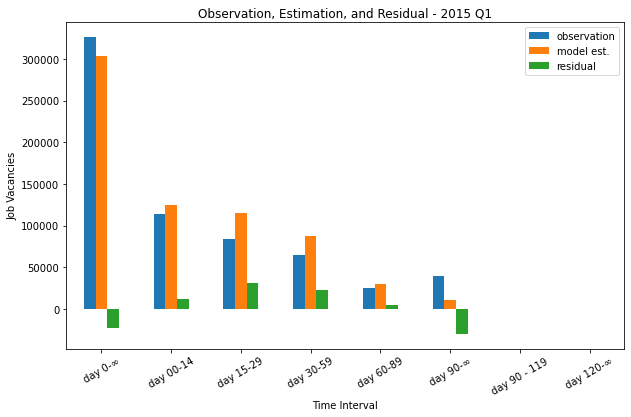

In [7]:
plot(df_all, 2015, 1)